# Traveling Salesman Problem via Genetic algorithms

Francesco Andreuzzi -- Data Science and Scientific Computing

Final project for the course "Computational Physics Laboratory" (2022/2023)

## The problem

The Traveling Salesman Problem (TSP) is a well known problem in Computer Science. It consists in finding the optimal (i.e. cheapest) tour which visits all cities in the instance, given a matrix of costs to travel from one to another. 
$$
\normalsize
\begin{align*}
\text{Minimize}& \qquad \sum_{i=1}^N \sum_{j=1}^N x_{ij} d_{ij} \\
\text{with}& \qquad \sum_{j=1}^N x_{ij} = 1 \qquad i = 1, \dots N \quad (\text{Exactly one incoming})\\
& \qquad \sum_{i=1}^N x_{ij} = 1 \qquad j = 1 \dots N \quad (\text{Exactly one outgoing})
\end{align*}
$$

It's NP-hard, therefore exact algorithms are unfeasible for non-trivial instances.

## Genetic algorithms overview

Genetic algorithms (GA) are approximation randomized algorithms which iteratively optimize a partial set of viable solutions to a given problem, often called *chromosomes*. The optimization is carried out on a given *fitness* function, which in our case is the cost of a given tour.

Optimization happens by a peculiar process called *crossover*, which consists in merging two parent solutions into a new one, hopefully retained the best parts of the ancestors. Many *crossover operators* exist for the TSP problem, some of them are fully deterministic (e.g. `CX`, `CX2`), while others are based on a stochastic component (e.g. `OX`, `PMX`).

In addition to crossover, to further mimic natural biological evolution, GA leverage *mutation* to slightly modify a subset of exising chromosomes (choosed randomly). This often provides solutions not easily achievable by means of crossover, and is critical in fully exploring the solution manifold. Due to their intrinsic stochastic definition, mutation operator are always randomized procedures which operate on a single chromosome.

## Structure of the project

We briefly describe the structure of the GitHub repository.

### Languages

The problem was tackled using Python and Fortran 90, leveraging [f2py](https://numpy.org/doc/stable/f2py/index.html) to link the two languages. Python was used to develop the high level driver for the genetic framework, the problem loading and the data collection layer, and to perform final data analysis, due to its strong versatility. Fortran was used to develop the low-level mutation and crossover operators.

Thanks to the link between Python and Fortran it has been possible to test the fortran code by using the high level Python testing framework [pytest](https://pytest.org), which among standard testing traits provides many comfortable features like a rich CLI and [fixtures](https://docs.pytest.org/en/6.2.x/fixture.html).

### Directories

```diff
$ tree -I 'venv|__pycache__|*.mod' --dirsfirst
.
├── data
-   │   # Problem data in XML format
│   │   ...
├── data-loader
-   │   # Responsible for loading problem data from XML
│   ├── load.py
-   │   # Problem representation as a Python class
│   └── problem.py
├── run
-   │   # Argparse CLI + utilities (logging, text display)
│   ├── data_storage.py
│   ├── printer.py
│   ├── run.py
│   └── utils.py
├── tests
-   │   # Pytest testing for low-level Fortran routines
│   ├── crossover
│   │   ├── test_crossover.py
│   │   ├── test_cx2-original.py
│   │   ├── test_cx2.py
│   │   ├── test_cx.py
│   │   ├── test_ox.py
│   │   └── test_pmx.py
│   ├── mutation
│   │   ├── test_central_inverse.py
│   │   ├── test_mutation.py
│   │   ├── test_reverse_sequence.py
│   │   └── test_twors.py
│   ├── test_problem.py
│   └── test_utils.py
├── tsp-genetic-f90
-   │   # Fortran implementation of low-level operators
│   ├── crossover
│   │   ├── cx2.f90
│   │   ├── cx2-original.f90
│   │   ├── cx.f90
│   │   ├── ox.f90
│   │   └── pmx.f90
│   ├── mutation
│   │   ├── central_inverse.f90
│   │   ├── reverse_sequence.f90
│   │   └── twors.f90
│   ├── problem.f90
│   └── utils.f90
├── tsp-genetic-py
-   │   # Genetic framework implementation
│   ├── configuration.py
│   ├── crossover.py
│   ├── evolve.py
│   ├── idata_logger.py
│   └── mutation.py
├── LICENSE
├── Makefile
├── README.md
-   # We are here
├── tsp-genetic-algorithms.ipynb
-   # Fortran code compiled with f2py
└── tsp_genetic.cpython-39-x86_64-linux-gnu.so
```

# High level objects
We defined some high level objects to ease starting a genetic optimization run.

## Problem object
TSP problems are taken from the [TSPLIB](http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/) repository, and are stored in the directory `data/` of the project. We represent them in Python with the [dataclass](https://docs.python.org/3/library/dataclasses.html) `Problem`, which contains the fields `name`, `cost_matrix` and `optimal_tour`.

In [1]:
import utils
from load import build_problem

build_problem("a280")

Problem(name='a280', cost_matrix=array([[20.        , 24.08318916, 32.984845  , ..., 43.26661531,
        34.40930107, 17.88854382],
       [20.        , 18.43908891, 34.17601498, ..., 36.22154055,
        28.        ,  8.94427191],
       [24.08318916, 18.43908891, 16.1245155 , ..., 19.6977156 ,
        10.77032961, 10.        ],
       ...,
       [43.26661531, 36.22154055, 19.6977156 , ..., 17.08800749,
         8.94427191, 29.12043956],
       [34.40930107, 28.        , 10.77032961, ..., 18.43908891,
         8.94427191, 20.39607805],
       [17.88854382,  8.94427191, 10.        , ..., 34.92849839,
        29.12043956, 20.39607805]]), optimal_tour=array([  1,   2, 242, 243, 244, 241, 240, 239, 238, 237, 236, 235, 234,
       233, 232, 231, 246, 245, 247, 250, 251, 230, 229, 228, 227, 226,
       225, 224, 223, 222, 221, 220, 219, 218, 217, 216, 215, 214, 213,
       212, 211, 210, 207, 206, 205, 204, 203, 202, 201, 198, 197, 196,
       195, 194, 193, 192, 191, 190, 189, 188, 187, 

## Configuration

We defined the dataclass `Configuration` to pack all needed configurations for a given genetic optimization run:

In [2]:
from configuration import Configuration
from dataclasses import fields

[field.name for field in fields(Configuration)]

['population_size',
 'elite_size',
 'n_generations',
 'mutation_operator',
 'mutation_probability',
 'mutation_function_degree',
 'mutation_function_adaptive',
 'crossover_operator',
 'crossover_strategy',
 'crossover_retainment',
 'next_generation_policy',
 'print_every']

# Genetic optimization

- Crossover operators
- Crossover strategy
- Mutation operators
- Mutation probability evolution
- Next generation policy & elitism

## Crossover operators

First of all we need to define a baseline configuration object for all the run we intend to perform.

In [3]:
from dataclasses import replace
from configuration import (
    Crossover,
    CrossoverStrategy,
    CrossoverRetainment,
    NextGenerationPolicy,
)
from mutation import Mutation
import numpy as np

base_config = Configuration(
    population_size=250,
    elite_size=0,
    n_generations=1000,
    crossover_operator=None,
    crossover_strategy=CrossoverStrategy.FITNESS_RANDOM_PAIRS,
    crossover_retainment=CrossoverRetainment.FIRST,
    next_generation_policy=NextGenerationPolicy.BEST,
    mutation_operator=Mutation.TWORS,
    mutation_probability=0.15,
    mutation_function_degree=0,
    mutation_function_adaptive=False,
    print_every=100,
)

generations = base_config.print_every * np.arange(
    1, base_config.n_generations // base_config.print_every + 1
)

We then tweak the object to inject specific crossover operators:

In [4]:
ox_config = replace(base_config, crossover_operator=Crossover.OX)
pmx_config = replace(base_config, crossover_operator=Crossover.PMX)
cx_config = replace(base_config, crossover_operator=Crossover.CX)
cx2_config = replace(base_config, crossover_operator=Crossover.CX2)

config = tuple((ox_config, pmx_config, cx_config, cx2_config))
labels = tuple(("OX", "PMX", "CX", "CX2"))

Then we load the problem objects from TSPLIB XML files:

In [5]:
problem_small = build_problem("eil76")
problem_big = build_problem("a280")

We are now ready to run the genetic optimization:

In [6]:
from utils import run_optimizations, run_many_optimizations

data_small = run_many_optimizations(problem_small, config)
data_big = run_many_optimizations(problem_big, config)

/home/fandreuz/code/tsp-genetic-algorithms/venv/lib64/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/fandreuz/code/tsp-genetic-algorithms/venv/lib64/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


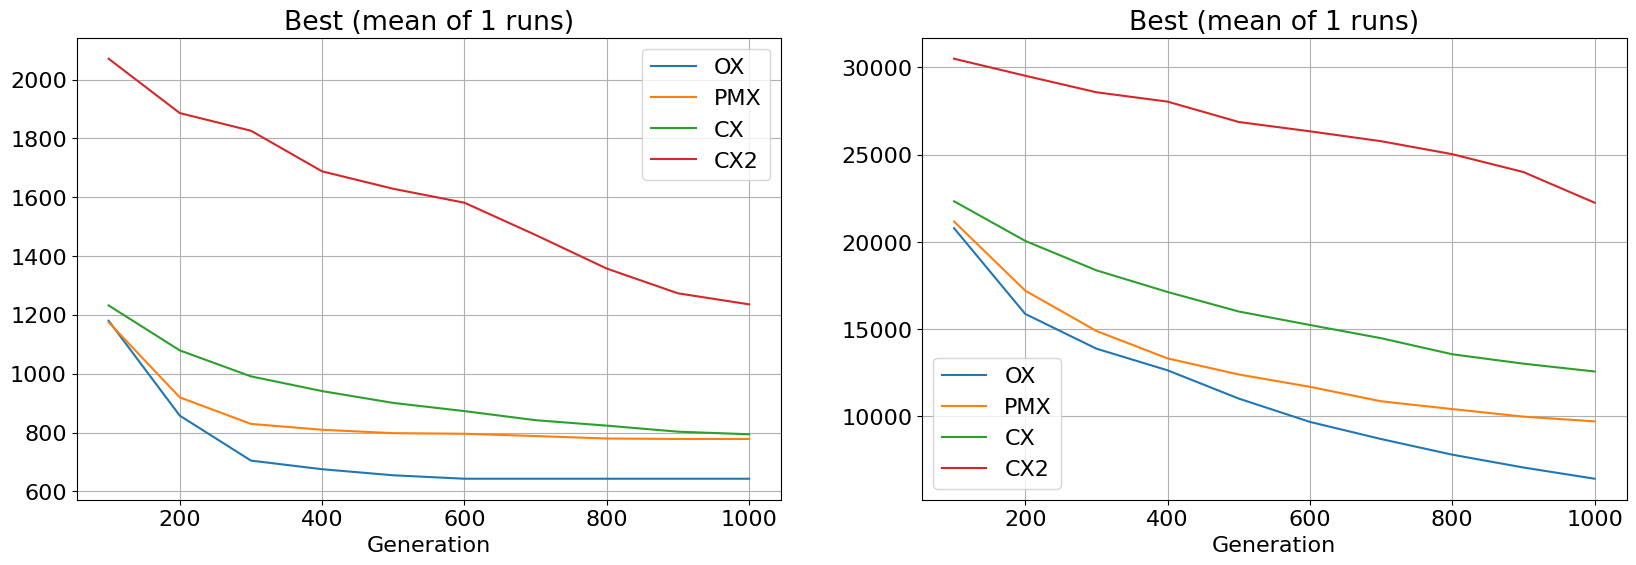

In [7]:
from utils import plot_big_and_small

plot_big_and_small(generations, data_small, data_big, labels)

It's quite evident that operators `OX` and `PMX` achieve much better results. Indeed, such operators try to preserve the relative order in the path, as opposed to cyclic operators which often disrupt the sequence. This finding is widely accepted in literature ([2]).

## Crossover strategy

There are a few options among which we can choose to select the parents which will be used for the crossover phase. The options are listed in the enum `CrossoverStrategy`, and characterize the set from which the crossover pairs will be drawn:
- `ALL_IN_ORDER`: all chromosomes in the previous generation are part of the selection process. Pairs are **always** formed in order (according to the fitness), therefore the selection is not random;
- `ALL_RANDOM_PAIRS`: like `ALL_IN_ORDER`, but pairs are formed randomly;
- `RANDOM_PAIRS`: pairs are drawn randomly with replacement, therefore each parent could be selected 0, 1 or more times;
- `FITNESS_RANDOM_PAIRS`: like `RANDOM_PAIRS`, but each parent is extracted with a probability which depends on `1/fitness`.

In [8]:
ox_aio_config = replace(ox_config, crossover_strategy=CrossoverStrategy.ALL_IN_ORDER)
ox_arp_config = replace(
    ox_config, crossover_strategy=CrossoverStrategy.ALL_RANDOM_PAIRS
)
ox_rp_config = replace(ox_config, crossover_strategy=CrossoverStrategy.RANDOM_PAIRS)

config = tuple((ox_config, ox_aio_config, ox_arp_config, ox_rp_config))
labels = tuple(
    map(
        str,
        (
            CrossoverStrategy.FITNESS_RANDOM_PAIRS,
            CrossoverStrategy.ALL_IN_ORDER,
            CrossoverStrategy.ALL_RANDOM_PAIRS,
            CrossoverStrategy.RANDOM_PAIRS,
        ),
    )
)

In [9]:
data_small = run_many_optimizations(problem_small, config)
data_big = run_many_optimizations(problem_big, config)

/home/fandreuz/code/tsp-genetic-algorithms/venv/lib64/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/fandreuz/code/tsp-genetic-algorithms/venv/lib64/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


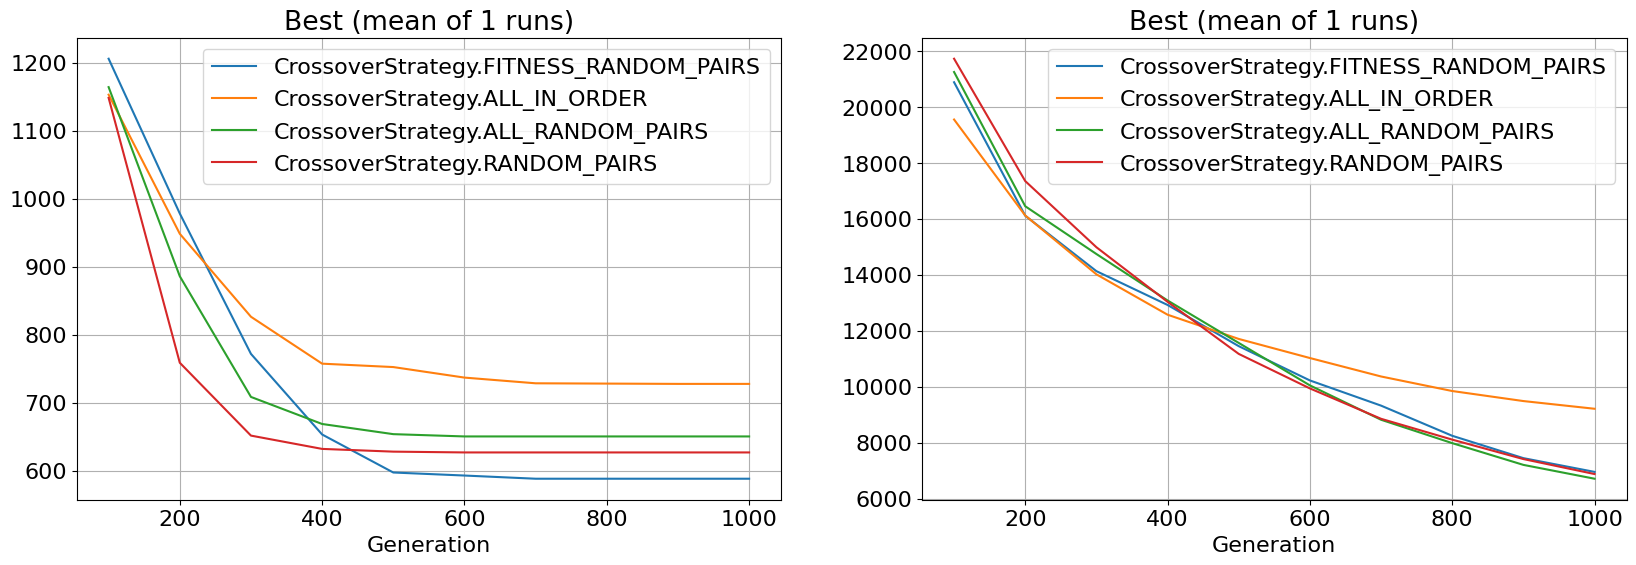

In [10]:
plot_big_and_small(generations, data_small, data_big, labels)


## Mutation operators
We now turn to the selection of an optimal mutation operator, among those which we implemented as part of the project:
- Twors (simple inversion)
- Central inverse
- Reverse sequence

In [26]:
ox_no_mutation = replace(ox_config, mutation_probability=0.0)
ox_twors_config = ox_config
ox_ci_config = replace(ox_config, mutation_operator=Mutation.CENTRAL_INVERSE)
ox_rs_config = replace(ox_config, mutation_operator=Mutation.REVERSE_SEQUENCE)

config = tuple((ox_no_mutation, ox_twors_config, ox_ci_config, ox_rs_config))
labels = tuple(("No mutation", "Twors", "Central inverse", "Reverse sequence"))

In [27]:
data_small = run_many_optimizations(problem_small, config)
data_big = run_many_optimizations(problem_big, config)

/home/fandreuz/code/tsp-genetic-algorithms/venv/lib64/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/fandreuz/code/tsp-genetic-algorithms/venv/lib64/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


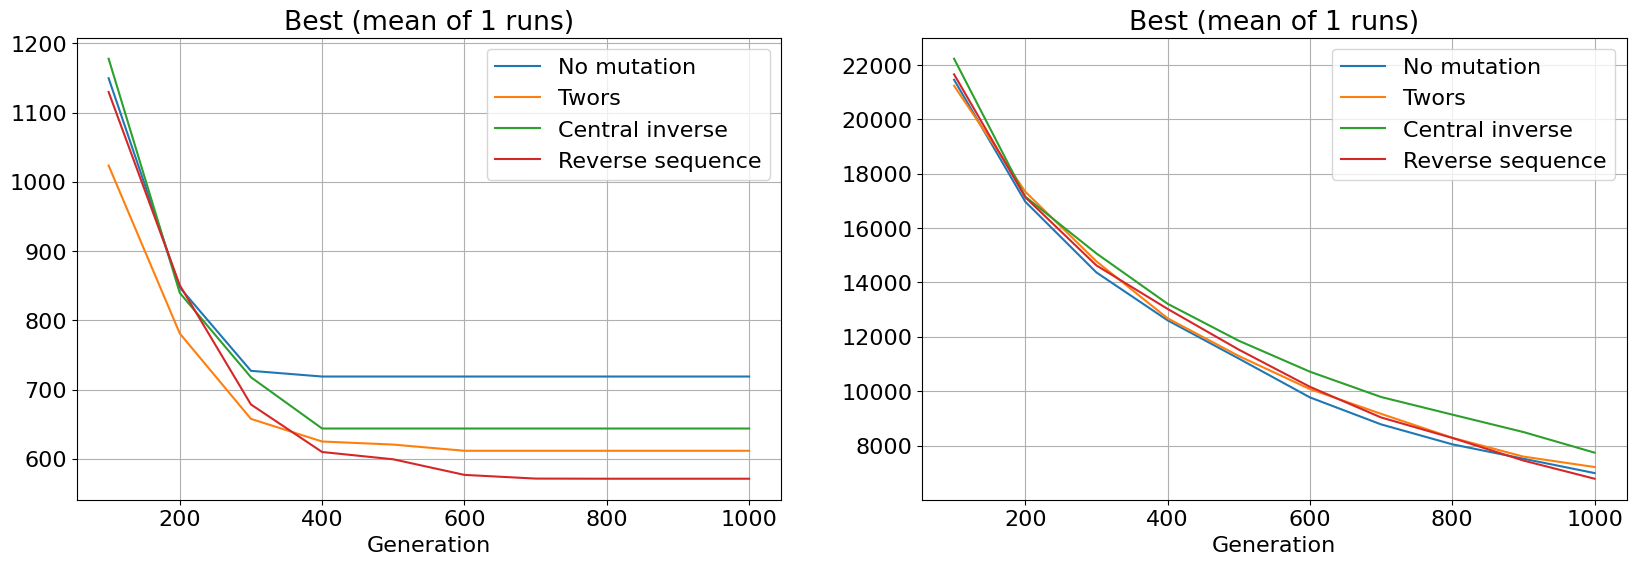

In [28]:
plot_big_and_small(generations, data_small, data_big, labels)

## Mutation probability evolution

As noted in [6], it's desirable to increase the mutation probability as the generation index increases, since the population of chromosomes tends to stagnate towards repeated high-fitness individuals. For this reason, extending the work presented in [6], we implemented a flexible evolution policy for the mutation probability, i.e. the probability that a given chromosome is subject to a mutation after crossover happens. The policy is parametrized by an integer number $k$, which acts as the polynomial degree of the function which describes the evolution of the probability in time.

The mutation probability $m$ for the generation $g$ is computed as follows:
$$
\normalsize
m(g) = \frac{M}{G^k} g^k
$$

given the total number of generations $G$ and the target mutation probability $M$.

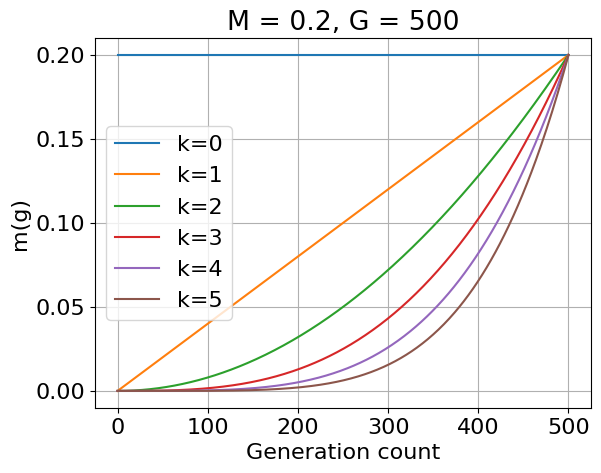

In [11]:
import matplotlib.pyplot as plt
from utils import setup_matplotlib

setup_matplotlib()

g = np.arange(501)
M = 0.2


def plot_evolution(k):
    plt.plot(g, M / g[-1] ** k * g**k, label=f"k={k}")


for i in range(6):
    plot_evolution(i)

plt.legend()

plt.xlabel("Generation count")
plt.ylabel("m(g)")
plt.title(f"M = {M}, G = {g[-1]}")
plt.grid()

plt.show()

We now verify whether varying the mutation rate linearly, quadratically or cubically makes any difference in the best individual produced by the optimization. We're going to use again `OX` crossover as it was the best candidate of the previous experiment.

In [29]:
ox1_config = replace(ox_rs_config, mutation_function_degree=1)
ox2_config = replace(ox_rs_config, mutation_function_degree=2)
ox3_config = replace(ox_rs_config, mutation_function_degree=3)

config = tuple((ox_rs_config, ox1_config, ox2_config, ox3_config))
labels = tuple(("OX", "OX - 1", "OX - 2", "OX - 3"))

In [30]:
data_small = run_many_optimizations(problem_small, config)
data_big = run_many_optimizations(problem_big, config)

/home/fandreuz/code/tsp-genetic-algorithms/venv/lib64/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/fandreuz/code/tsp-genetic-algorithms/venv/lib64/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


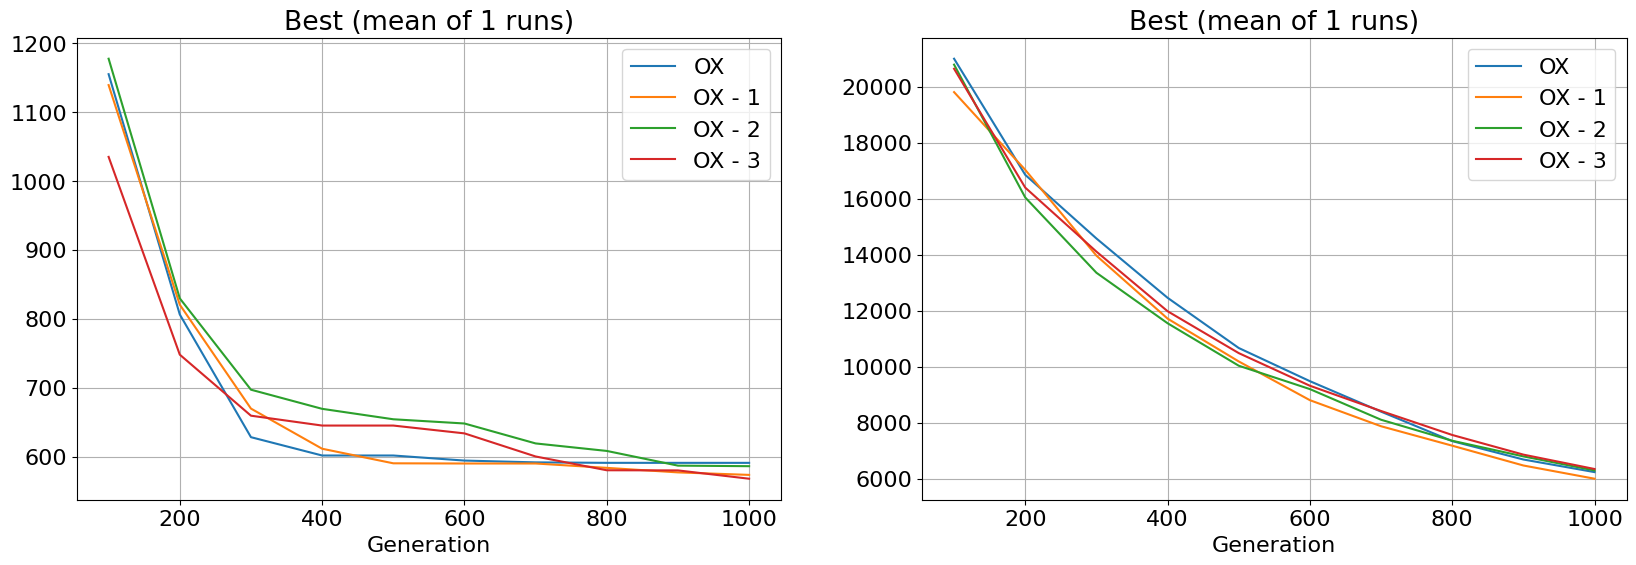

In [31]:
plot_big_and_small(generations, data_small, data_big, labels)

From the plot above, it looks like the well-known observation that varying the mutation probability throughout the optimization run has been confirmed, but there's not much difference in how it varies (at least as long as polynomial functions are taken into account).

## Adaptive mutation probability

In [32]:
ox1_config = replace(
    ox_rs_config, mutation_function_adaptive=True, mutation_probability=0.1
)
ox4_config = replace(
    ox_rs_config, mutation_function_adaptive=True, mutation_probability=0.4
)
ox10_config = replace(
    ox_rs_config, mutation_function_adaptive=True, mutation_probability=1
)

config = tuple((ox_rs_config, ox1_config, ox4_config, ox10_config))
labels = tuple(("OX", "OX - Adaptive 10%", "OX - Adaptive 40%", "OX - Adaptive 100%"))

In [33]:
data_small = run_many_optimizations(problem_small, config)
data_big = run_many_optimizations(problem_big, config)

/home/fandreuz/code/tsp-genetic-algorithms/venv/lib64/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/fandreuz/code/tsp-genetic-algorithms/venv/lib64/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


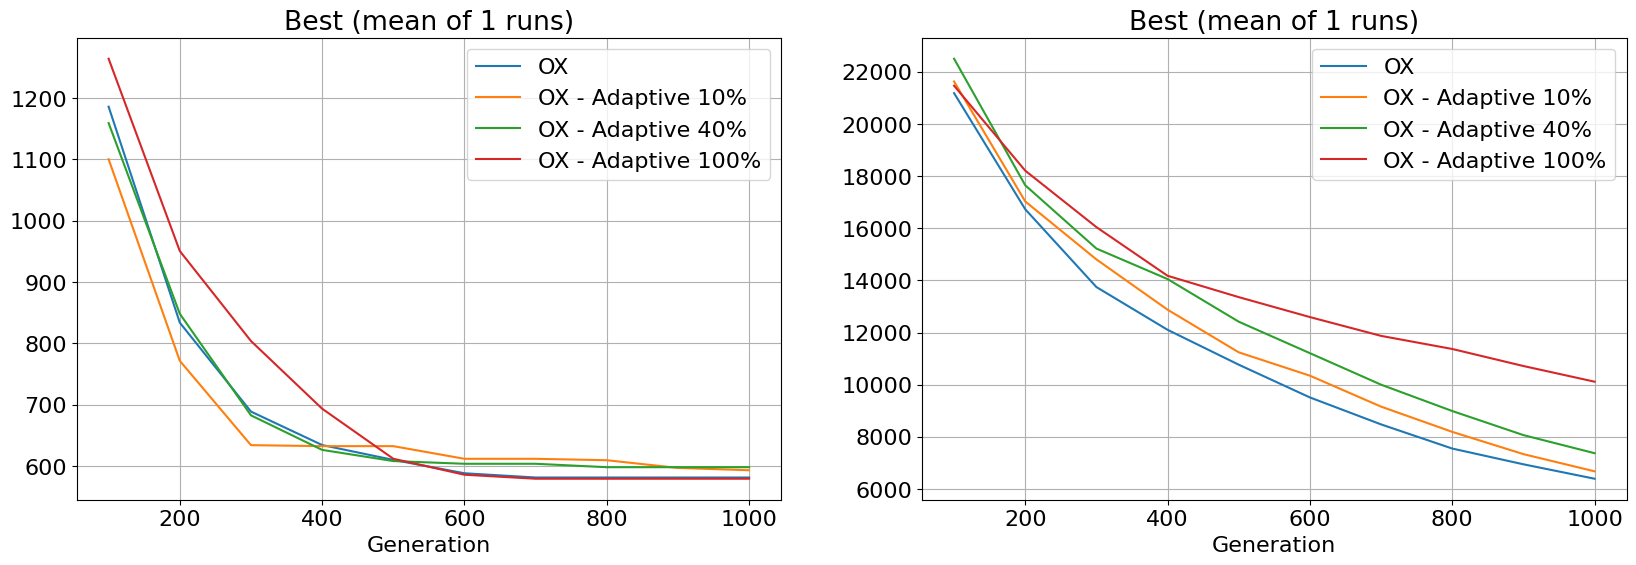

In [34]:
plot_big_and_small(generations, data_small, data_big, labels)

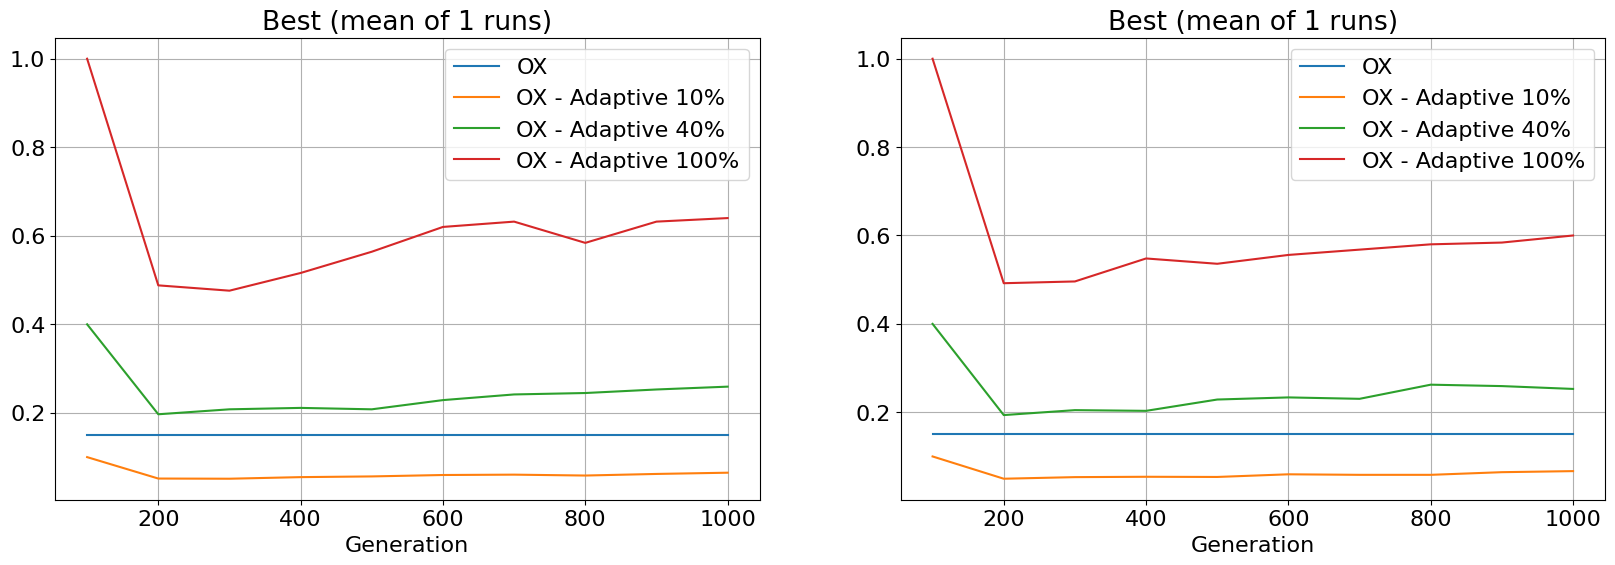

In [35]:
from operator import attrgetter

plot_big_and_small(
    generations,
    data_small,
    data_big,
    labels,
    data_operator=attrgetter("mutation_probability"),
)

## Next generation policy

The replacement of the old generation with the new one can be performed in two ways, which we collected in the enum `NextGenerationPolicy`:
- `REPLACE_ALL`: Replace the whole old generation with the new generation;
- `BEST`: Retain the first `N` best individuals according to fitness.

Moreover, for the policy `REPLACE_ALL` we could apply *elitism* [2]: a small percentage of top performing chromosomes from the old generation is retained irrespective of their rank. 

In [22]:
ox_ra_el0_config = replace(
    ox_ci_config, next_generation_policy=NextGenerationPolicy.REPLACE_ALL, elite_size=0
)
ox_ra_el01_config = replace(ox_ra_el0_config, elite_size=0.1)
ox_ra_el03_config = replace(ox_ra_el0_config, elite_size=0.3)
ox_best_config = replace(
    ox_ra_el0_config, next_generation_policy=NextGenerationPolicy.BEST
)

config = tuple((ox_ra_el0_config, ox_ra_el01_config, ox_ra_el03_config, ox_best_config))
labels = tuple(
    (
        "REPLACE_ALL - Elitism=0%",
        "REPLACE_ALL - Elitism=10%",
        "REPLACE_ALL - Elitism=30%",
        "BEST",
    )
)

In [23]:
data_small = run_many_optimizations(problem_small, config)
data_big = run_many_optimizations(problem_big, config)

/home/fandreuz/code/tsp-genetic-algorithms/venv/lib64/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/fandreuz/code/tsp-genetic-algorithms/venv/lib64/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


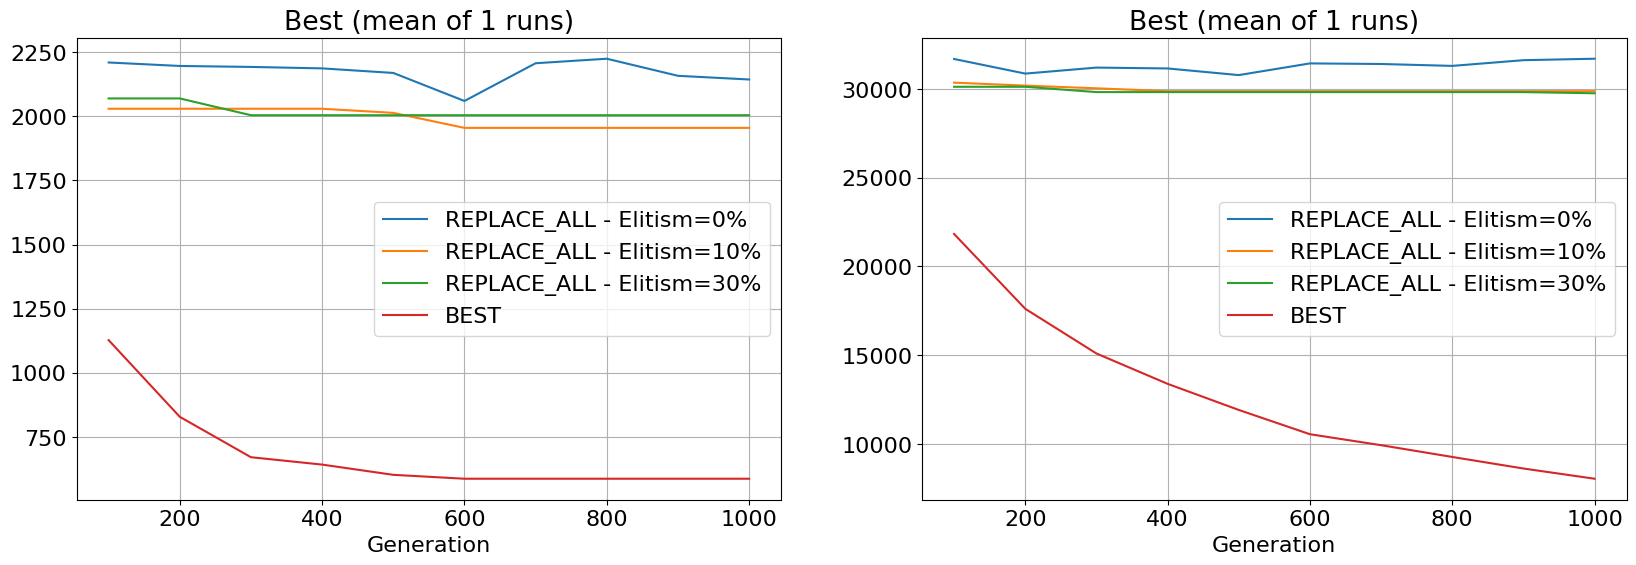

In [24]:
plot_big_and_small(generations, data_small, data_big, labels)

# Other topics

## Implementation of `CX2`

The MATLAB code in [3] proposed as the official implementation of `CX2` is clearly inefficient due to the frequent restort to the `find()` function, which is $\Theta(N)$. Since the crossover requires a linear scan of the array, the implementation in [3] is $\Theta(N^2)$.

For this reason we re-implemented it by leveraging a pre-built index, which makes the function $\Theta(N)$.

Output()

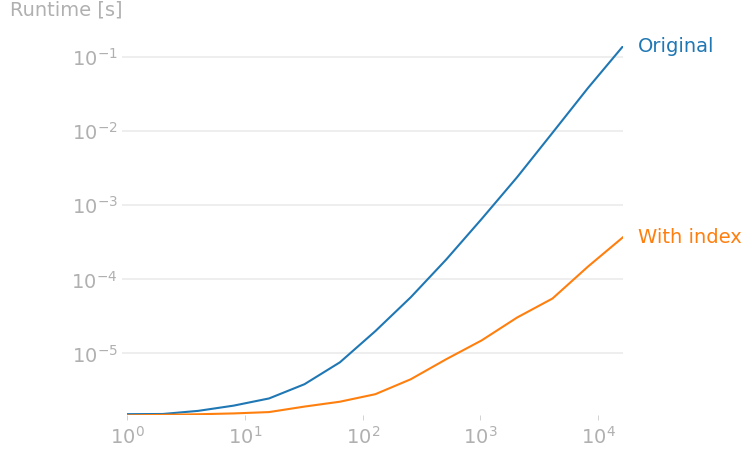

In [25]:
from tsp_genetic import cx2, cx2_original
import perfplot

perfplot.show(
    setup=lambda n: ((np.random.permutation(n) + 1, np.random.permutation(n) + 1),),
    kernels=[
        lambda a: cx2_original(*a),
        lambda a: cx2(*a),
    ],
    labels=["Original", "With index"],
    n_range=[2**k for k in range(15)],
    show_progress=False,
)

setup_matplotlib()

# Conclusion

## Unexplored directions

It could be interesting to take into account various ways to generate the initial generation of chromosomes. In this project we've only considered the randomized permutation of the list of cities, but more refined approaches exist to guarantee a better coverage on the solution manifold.

## References

1. Deep, Kusum, and Hadush Mebrahtu. "New variations of order crossover for travelling salesman problem." International Journal of Combinatorial Optimization Problems and Informatics 2.1 (2011): 2-13.
1. Potvin, Jean-Yves. "Genetic algorithms for the traveling salesman problem." Annals of Operations Research 63 (1996): 337-370.
1. Hussain, Abid, et al. "Genetic algorithm for traveling salesman problem with modified cycle crossover operator." Computational intelligence and neuroscience 2017 (2017).
1. Kumar, Rakesh, Girdhar Gopal, and Rajesh Kumar. "Novel crossover operator for genetic algorithm for permutation problems." International Journal of Soft Computing and Engineering (IJSCE) 3.2 (2013): 252-258.
1. Abdoun, Otman, Jaafar Abouchabaka, and Chakir Tajani. "Analyzing the performance of mutation operators to solve the travelling salesman problem." arXiv preprint arXiv:1203.3099 (2012).
1. Hassanat, Ahmad, et al. "Choosing mutation and crossover ratios for genetic algorithms—a review with a new dynamic approach." Information 10.12 (2019): 390.
1. f2py official documentation: https://numpy.org/doc/stable/f2py/

## Open source software

- argparse: https://docs.python.org/3/library/argparse.html
- f2py: https://numpy.org/doc/stable/f2py/
- Matplotlib: https://matplotlib.org
- NumPy: https://numpy.org
- Python standard library: https://docs.python.org/3/library/
- pytest: https://pytest.org
- perfplot: https://github.com/nschloe/perfplot

## Data

- TSPLIB: http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/